In [1]:
pip install gudhi -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi
from tqdm import tqdm
import transformers
from transformers import pipeline
from transformers import BertTokenizer, BertModel
import torch

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
text = "Replace me by any text you'd like to answer."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
query = model.encoder.layer[0].attention.self.query.weight
key = model.encoder.layer[0].attention.self.key.weight
value = model.encoder.layer[0].attention.self.value.weight

d_k = key.size(-1)

attention = ((query @ key.T) / (d_k**0.5)) @ value
# attention = torch.nn.functional.softmax(attention, )
# attention_probs = torch.nn.functional.softmax(scores, dim=-1)

In [6]:
attention = attention.detach().numpy()
attention.shape

(768, 768)

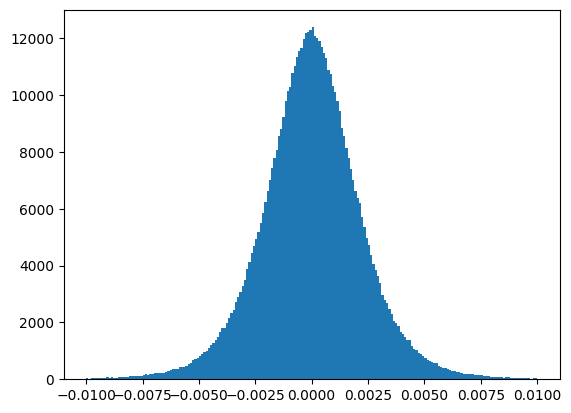

In [7]:
plt.hist(attention.flatten(), bins = 200, range = (-0.01,0.01))
plt.show()

In [8]:
threshold = 0.0045
A = np.where(attention > threshold, attention, 0)

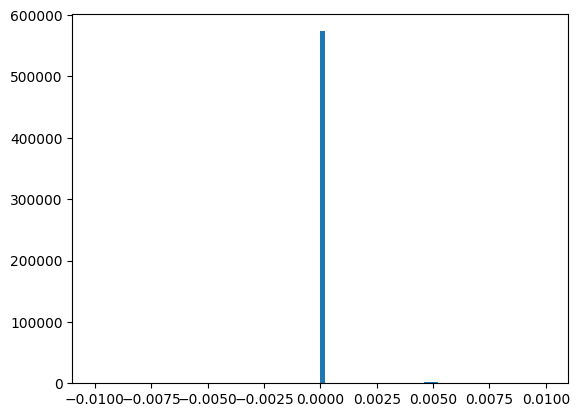

In [9]:
plt.hist(A.flatten(), bins = 100, range = (-0.01,0.01))
plt.show()

In [10]:
# A = np.array([[1,0,0],
#               [1,1,0],
#               [1,0,1],
#               [0,1,1]])

In [11]:
# A = np.array([[1,0,0,0],
#               [1,1,0,0],
#               [1,1,1,0],
#               [0,0,0,1]])

In [24]:
A = np.array([[1,0,0,0,0,0,0],
              [1,1,0,0,0,0,0],
              [1,1,1,0,0,0,0],
              [0,0,0,1,1,0,0],
              [0,0,0,0,1,1,0],
              [0,0,0,1,0,1,0]])

In [33]:
simp[1].shape[0] == 0

True

In [16]:
complex = SimplicialComplex()

In [25]:
simp = []
for i in tqdm(range(A.shape[0])):
  simplex = np.nonzero(A[i])[0]
  if simplex.shape[0] != 0:
    simp.append(simplex)
    complex.add(simplex)

 33%|███▎      | 2/6 [00:00<00:00, 40.17it/s]


AttributeError: 'list' object has no attribute 'tolist'

In [37]:
len(simp)

692

In [31]:
attention.shape

(768, 768)

# simplicialx

In [21]:
import pickle
import numpy as np
import networkx as nx

from itertools import combinations
from sympy.combinatorics.permutations import Permutation


class SimplicialComplex:
    __slots__ = [
        '_simplices',
        '_weights',
        '_kind',
        '_hasse',
        # caches
        '_cache_bom',
        '_cache_lg',
    ]

    # ========== INITIALIZATION AND ATTRIBUTES ========== #

    def __init__(self):
        self._simplices: list[np.ndarray] = []
        self._weights: dict = {}
        self._kind = None
        self._hasse = None
        # caches
        self._cache_bom: dict = {}
        self._cache_lg: dict = {}

    @property
    def simplices(self):
        return self._simplices

    @property
    def weights(self):
        return self._weights

    @property
    def kind(self):
        return self._kind

    @property
    def hasse_graph(self):
        if self._hasse is not None:
            return self._hasse.copy()
        return None

    @simplices.setter
    def simplices(self, new_simplices):
        if new_simplices == []:
            self.clear()

        else:
            _check_n_simpl_complex(new_simplices)

            simplices = []
            weights = {}
            dim = len(new_simplices) - 1

            for iteration in range(dim + 1):
                simplices.append(np.sort(np.unique(np.array(new_simplices[iteration]), axis=0)).astype('int'))

            for i in range(dim + 1):
                smps = simplices[i]
                for simplex in smps:
                    weights[tuple(simplex)] = 1.

            self._simplices = simplices
            self._weights = weights
            self._cache_bom = {}
            self._cache_lg = {}

    @weights.setter
    def weights(self, new_weights):
        _check_weights(new_weights)

        dim = len(self._simplices) - 1

        for i in range(dim + 1):
            simplices = self._simplices[i]

            for simplex in simplices:
                if tuple(simplex) not in new_weights.keys():
                    raise ValueError('Weights must be specified for all simplices in the complex')

        self._weights = new_weights

    @kind.setter
    def kind(self, new_kind):
        if new_kind is not None:
            _check_kind(new_kind)

        self._kind = new_kind

    # ========== PROPERTIES ========== #

    @property
    def f_vector(self):
        res = [s.shape[0] for s in self._simplices]
        return np.array(res).astype('int')

    @property
    def euler_characteristic(self) -> int:
        alternating_sign = np.array([(-1) ** i for i in range(len(self._simplices))])
        res = self.f_vector @ alternating_sign
        return res.astype('int')

    @property
    def dim(self):
        res = len(self._simplices) - 1
        if res < 0:
            return None
        return res

    @property
    def simplices_num(self) -> int:
        res = np.sum(self.f_vector)
        return res.astype('int')

    def __len__(self) -> int:
        return self.simplices_num

    # ========== MODIFYING FUNCTIONS ========== #

    def clear(self):
        self._simplices = []
        self._weights = {}
        self._kind = None
        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

    def copy(self):
        res = SimplicialComplex()

        res._simplices = self._simplices.copy()
        res._weights = self._weights.copy()
        res.kind = self.kind
        if self._hasse is not None:
            res._hasse = self._hasse.copy()

        return res

    def add(self, simplex, weight=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)
        if not isinstance(weight, (float, int)):
            raise TypeError('Incorrect type of weight: must be int or float')

        k = simplex.shape[0] - 1
        dim = len(self._simplices) - 1

        if k <= dim and simplex.tolist() in self._simplices[k].tolist():
            return

        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

        for i in range(min(k + 1, dim + 1)):
            self._simplices[i] = self._simplices[i].tolist()

        if k > dim:
            for i in range(dim + 1, k + 1):
                self._simplices.append([])

        for i in range(k + 1):
            for face in combinations(simplex, i + 1):
                sub_s = list(face)

                if sub_s in self._simplices[i]:
                    continue

                self._simplices[i].append(sub_s)
                self._weights[tuple(sub_s)] = 1.

                # TODO:
                '''
                if self._hasse is not None:
                    self._add_hasse(sub_s, i-1)
                '''

            self._simplices[i] = np.unique(np.array(self._simplices[i]), axis=0).astype('int')

        self._weights[tuple(simplex)] = weight

    def remove(self, simplex):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)

        k = simplex.shape[0] - 1
        dim = len(self._simplices) - 1

        if dim < k or simplex.tolist() not in self._simplices[k].tolist():
            return

        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

        for i in range(k, dim + 1):
            self._simplices[i] = self._simplices[i].tolist()

        for i in range(dim, k - 1, -1):
            cofaces = self._cofaces(simplex, i)

            for coface in cofaces:
                s = list(coface)
                self._simplices[i].remove(s)
                self._weights.pop(tuple(s), None)

                # TODO:
                '''
                if self._hasse is not None:
                    self._hasse.remove_node(tuple(s))
                '''

            if not self._simplices[i]:
                self._simplices = self._simplices[:i]
            else:
                self._simplices[i] = np.array(self._simplices[i]).astype('int')

    def update(self, simplex, weight=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)
        if not isinstance(weight, (float, int)):
            raise TypeError('Incorrect type of weight: must be int or float')

        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)

        self._weights[tuple(simplex)] = weight

    def weight_threshold(self, threshold):
        if not isinstance(threshold, (float, int)):
            raise TypeError('Incorrect type of threshold: must be int or float')

        dim = len(self._simplices) - 1

        for i in range(dim, 0, -1):
            for simplex in self._simplices[i]:
                if self._weights[tuple(simplex)] < threshold:
                    self.remove(simplex)

    # Tech Funcs #

    def _add_hasse(self, s_list, n):
        k = len(s_list) - 1
        order = k - n

        if n < 0 or order <= 0:
            return

        faces = self._faces(s_list, n)
        for face in faces:
            self._hasse.add_edge(tuple(face), tuple(s_list), order=order, kind="coboundary")
            self._hasse.add_edge(tuple(s_list), tuple(face), order=order, kind="boundary")

    # ========== SERIALIZING FUNCTIONS ========== #

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    # ========== BUILDING COMPLEX ========== #

    @classmethod
    def from_graph(cls, graph, kind='clique', n_skeleton=2, weighted=False):
        if isinstance(graph, nx.classes.graph.Graph):
            X = nx.to_numpy_array(graph)
        else:
            _check_adjacency_matrix(graph)
            X = graph.copy()
        np.fill_diagonal(X, 0)

        res = cls()
        res.kind = kind

        n_skeleton = _check_integer_values(n_skeleton=n_skeleton)
        if n_skeleton < 0:
            raise ValueError('Incorrect value of n_skeleton: must be >= 0')

        # main part

        if kind == 'clique':

            if not weighted:
                res._simplices = res._get_clique_complex_vr(X, n_skeleton)

                weights = {}
                dim = len(res._simplices) - 1

                for i in range(dim + 1):
                    simplices = res._simplices[i]
                    for simplex in simplices:
                        weights[tuple(simplex)] = 1.

                res._weights = weights

            else:
                res._simplices, res._weights = res._get_weighted_clique_complex(X, n_skeleton)

        elif kind == 'neighborhood':
            res._simplices, res._weights = res._get_neighborhood_dowker_complex(X, n_skeleton, weighted)

        elif kind == 'dowker':
            res._simplices, res._weights = res._get_neighborhood_dowker_complex(X, n_skeleton, weighted, nb=False)

        return res

    # Tech Funcs #

    def _get_neighborhood_dowker_complex(self, X, n_skeleton, weighted, nb=True):
        X_cur = X.copy()

        N, res, res_weights = X_cur.shape[0], [[]], {}

        if nb:
            np.fill_diagonal(X_cur, 1)

        for i in range(N):
            res[0].append([i])
            res_weights[tuple([i])] = 1.

        res[0] = np.array(res[0])

        row_ind, row = X_cur.nonzero()

        for iteration in range(1, n_skeleton + 1):
            res.append([])

            for i in range(N):
                simplex = row[row_ind == i]
                n = simplex.shape[0]
                if n - 1 - iteration < 0:
                    continue
                subsimplex_arr = self._get_subsimplex_array(simplex, diff=n - 1 - iteration)
                res[iteration] += list(subsimplex_arr)

            res[iteration] = np.sort(np.unique(np.array(res[iteration]), axis=0)).astype('int')

            if len(res[iteration]) == 0:
                res.pop()
                break

            for simplex in res[iteration]:
                if not weighted:
                    res_weights[tuple(simplex)] = 1.

                else:

                    if iteration == 1:
                        res_weights[tuple(simplex)] = X[simplex[0]][simplex[1]]

                    else:
                        weight = -np.inf

                        for prev_simplex in self._get_subsimplex_array(simplex):
                            prev_simplex_weight = res_weights[tuple(prev_simplex)]
                            weight = np.maximum(weight, prev_simplex_weight)

                        res_weights[tuple(simplex)] = weight

        return res, res_weights

    def _get_clique_complex_vr(self, X, n_skeleton):

        n_skeleton = n_skeleton + 1

        def _add_cofaces(A, k, tau, N_lower, simplices):

            simplices.append(tau)

            if len(tau) >= k:
                return

            else:
                for v in N_lower:
                    sigma = sorted(tau + [v])
                    M = _intersect([N_lower, _neighbors_lower(v, A)])
                    _add_cofaces(A, k, sigma, M, simplices)

            return simplices

        def _neighbors_lower(x_id, A):
            LT = np.tril(A)
            return list(np.nonzero(LT[x_id])[0])

        def _intersect(d):
            return list(set(d[0]).intersection(*d))

        def _grade(K):
            dim = len(max(K, key=len))
            K_graded = [[] for _ in range(dim)]

            for sigma in K:
                dim_sigma = len(sigma) - 1

                if dim_sigma == 0:
                    sigma = sigma[0]
                K_graded[dim_sigma].append(sigma)

            for k, item in enumerate(K_graded):
                if k == 0:
                    item_array = np.expand_dims(np.array(item), 1)
                else:
                    item_array = np.array(item)

                K_graded[k] = item_array

            return K_graded

        simplices = []

        V = list(range(X.shape[0]))

        for u in V:
            N_lower = _neighbors_lower(u, X)
            _add_cofaces(X, n_skeleton, [u], N_lower, simplices)

        res = _grade(simplices)

        for i in range(len(res)):
            res[i] = np.sort(np.unique(np.array(res[i]), axis=0)).astype('int')

        return res

    def _get_weighted_clique_complex(self, X, n_skeleton=2):
        N, res_weights = X.shape[0], {}

        res = self._get_clique_complex_vr(X, n_skeleton)

        for i in range(N):
            res_weights[tuple([i])] = 1.

        for iteration in range(1, len(res)):
            if len(res[iteration]) == 0:
                res = res[:iteration]
                break

            for simplex in res[iteration]:
                if iteration == 1:
                    res_weights[tuple(simplex)] = X[simplex[0]][simplex[1]]

                else:
                    weight = -np.inf

                    for prev_simplex in self._get_subsimplex_array(simplex):
                        prev_simplex_weight = res_weights[tuple(prev_simplex)]
                        weight = np.maximum(weight, prev_simplex_weight)

                    res_weights[tuple(simplex)] = weight

        return res, res_weights

    def _get_subsimplex_array(self, simplex, diff=1):
        n = len(simplex)
        res = []

        _check_simplex(simplex)
        diff = _check_integer_values(diff=diff)
        if diff < 0 or diff >= n:
            raise ValueError('Incorrect diff value: must be >= 0 and <= simplex dim')

        for sub_simplex in list(combinations(simplex, n - diff)):
            res.append(sub_simplex)

        return np.array(res)

    def _is_subsimplex(self, a, b):
        return set(a).issubset(set(b))

    # ========== BUILDING HASSE DIAGRAM ========== #

    def build_hasse_diagram(self):
        res = self._build_hasse()
        self._hasse = res

    def build_hasse_diagram_fc(self):
        res = self._build_hasse_fc()
        self._hasse = res

    def hasse_visualization(self, align='vertical', scale=1, center=None,
                            arrows=None, with_labels=True, **kwargs):
        if self._hasse is None:
            raise RuntimeError('Use build_hasse_diagram() or build_hasse_diagram_fc() first')

        pos = nx.multipartite_layout(self._hasse, 'dim', align=align, scale=scale, center=center)

        if arrows is not None:
            nx.draw(self._hasse, pos, arrows=arrows, with_labels=with_labels, **kwargs)
        else:
            nx.draw(self._hasse, pos, with_labels=with_labels, **kwargs)

    # Tech Funcs #

    def _build_hasse(self):
        res = nx.DiGraph()
        dim = self.dim

        if dim is None or dim < 1:
            return res

        for i in range(0, dim):
            order = 1

            for sub_s in self._simplices[i]:
                cofaces = self._cofaces(sub_s, i + 1)

                for s in cofaces:
                    res.add_edge(tuple(sub_s), tuple(s), order=order, kind="coboundary")
                    res.add_edge(tuple(s), tuple(sub_s), order=order, kind="boundary")

        for node in res.nodes:
            res.nodes[node]['dim'] = len(node) - 1

        return res

    def _build_hasse_fc(self):
        res = nx.DiGraph()
        dim = self.dim

        if dim is None or dim < 1:
            return res

        for i in range(0, dim):
            for j in range(i + 1, dim + 1):
                order = j - i

                for sub_s in self._simplices[i]:
                    cofaces = self._cofaces(sub_s, j)

                    for s in cofaces:
                        res.add_edge(tuple(sub_s), tuple(s), order=order, kind="coboundary")
                        res.add_edge(tuple(s), tuple(sub_s), order=order, kind="boundary")

                        res.nodes[tuple(sub_s)]['dim'] = len(sub_s) - 1
                        res.nodes[tuple(s)]['dim'] = len(s) - 1

        for node in res.nodes:
            res.nodes[node]['dim'] = len(node) - 1

        return res

    # ============= LINE GRAPH ============= #

    def line_graph(self, p=1, q=0, weighted=False):
        p, q = _check_integer_values(p=p, q=q)
        if p < 0:
            raise ValueError('Incorrect value of p: must be >= 0')
        if q < 0:
            raise ValueError('Incorrect value of q: must be >= 0')
        if p == q:
            raise ValueError('Incorrect value of p and q: must be p != q')

        res = nx.Graph()

        if max(p, q) > len(self._simplices) - 1:
            return res

        if (p, q, int(weighted)) in self._cache_lg.keys():
            return self._cache_lg[(p, q, int(weighted))].copy()

        if p > q:
            B = self.boundary_operator_matrix(k=p, p=p-q)
            adj = np.abs(B.T @ B)
        else:
            B = self.boundary_operator_matrix(k=q, p=q-p)
            adj = np.abs(B @ B.T)

        np.fill_diagonal(adj, 0)
        adj = adj != 0
        simplices = self._simplices[p]

        for i, idx in enumerate(adj):
            simplex = simplices[i]
            s_connected_list = simplices[idx]

            for s_connected in s_connected_list:
                if not weighted:
                    res.add_edge(tuple(simplex), tuple(s_connected), weight=1.)

                else:
                    if p > q:
                        filter_f = lambda x: self._is_subsimplex(x, simplex) and self._is_subsimplex(x, s_connected)
                    else:
                        filter_f = lambda x: self._is_subsimplex(simplex, x) and self._is_subsimplex(s_connected, x)

                    connections = list(filter(filter_f, self._simplices[q]))
                    weight = min([self._weights[tuple(x)] for x in connections])

                    res.add_edge(tuple(simplex), tuple(s_connected), weight=weight)

        self._cache_lg[(p, q, int(weighted))] = res

        return res.copy()

    def line_graph_shortest_paths(self, p=1, q=0, weighted=False):
        g = self.line_graph(p=p, q=q, weighted=weighted)
        res = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
        return res

    def line_graph_diameter(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.diameter(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.diameter(g, e=eccs)
            return res

    def line_graph_radius(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.radius(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.radius(g, e=eccs)
            return res

    def line_graph_center(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.center(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.center(g, e=eccs)
            return res

    def line_graph_periphery(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.periphery(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.periphery(g, e=eccs)
            return res

    def line_graph_connected_components_number(self, p=1, q=0):
        g = self.line_graph(p=p, q=q, weighted=False)
        res = nx.number_connected_components(g)
        return res

    # =========== SIMPLEX CENTRALITIES =========== #

    def simplex_betweenness_centrality(self, p=1, q=0, weighted=False, edge=False, normalized=True, **kwargs):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)

            if not edge:
                res = nx.betweenness_centrality(g, weight=None, normalized=normalized, **kwargs)
                return res

            else:
                res = nx.edge_betweenness_centrality(g, weight=None, normalized=normalized, **kwargs)
                return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)

            if not edge:
                res = nx.betweenness_centrality(g, weight='weight', normalized=normalized, **kwargs)
                return res

            else:
                res = nx.edge_betweenness_centrality(g, weight='weight', normalized=normalized, **kwargs)
                return res

    def simplex_closeness_centrality(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.closeness_centrality(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            res = nx.closeness_centrality(g, distance='weight')
            return res

    def simplex_eccentricity(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.eccentricity(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            res = nx.eccentricity(g, sp=dists)
            return res

    def simplex_clustering(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.clustering(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            res = nx.clustering(g, weight='weight')
            return res

    # ========== CALCULATING BOUNDARY OPERATORS ========== #

    def boundary_operator_matrix(self, k=1, p=1):
        orient = 1
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if orient not in [-1, 1]:
            raise ValueError('Incorrect value of orient: must be 1 or -1')
        if k > len(self._simplices) - 1:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex')

        simplex_list = self.simplices[k]
        prev_simplex_list = self.simplices[k - p]

        len_simplex_list = len(simplex_list)
        len_prev_simplex_list = len(prev_simplex_list)

        if len_prev_simplex_list == 0:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')
        elif len_simplex_list == 0:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex')

        if (k, p) in self._cache_bom.keys():
            return self._cache_bom[(k, p)].copy()

        if p == 1:
            res = self._get_bo_matrix_without_permutation(simplex_list, prev_simplex_list, k, orient)
            self._cache_bom[(k, p)] = res
            return res.copy()

        res = np.zeros((len_prev_simplex_list, len_simplex_list))

        for i, simplex in enumerate(simplex_list):
            for s in combinations(simplex, k - p + 1):
                prev_simplex = np.array(s)

                idx = np.isin(simplex, prev_simplex)
                pos = np.array(range(k + 1))

                vertices_in = list(pos[idx])
                vertices_out = list(pos[~idx])
                sign = orient * Permutation(vertices_out + vertices_in).signature()

                ind = np.flatnonzero(np.equal(prev_simplex_list, prev_simplex).all(axis=1))[0]
                res[ind][i] = sign

        self._cache_bom[(k, p)] = res

        return res.copy()

    # Tech Funcs #

    def _get_bo_matrix_without_permutation(self, simplex_list, prev_simplex_list, k, orient):
        len_simplex_list = len(simplex_list)
        len_prev_simplex_list = len(prev_simplex_list)

        res = np.zeros((len_prev_simplex_list, len_simplex_list))

        for i, simplex in enumerate(simplex_list):
            sign = orient

            for j in range(k + 1):
                idx = np.ones(k + 1).astype(bool)
                idx[j] = False
                prev_simplex = simplex[idx]

                ind = np.flatnonzero(np.equal(prev_simplex_list, prev_simplex).all(axis=1))[0]
                res[ind][i] = sign
                sign = -sign

        return res

    # ============ FACES AND COFACES ============ #

    def faces(self, simplex, p=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)

        _check_simplex(simplex)
        p = _check_integer_values(p=p)
        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)
        if p < 0 or p > n:
            raise ValueError('Incorrect p value: must be >= 0 and <= simplex dim')

        res = self._faces(simplex, n=n - p)

        # return self._get_subsimplex_array(simplex, diff=p)
        return np.array(res)

    def cofaces(self, simplex, q=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)

        _check_simplex(simplex)
        q = _check_integer_values(q=q)
        if q < 0:
            raise ValueError('Incorrect q value: must be >= 0')

        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)
        dim = len(self._simplices) - 1

        if n + q > dim:
            return np.array([])

        res = self._cofaces(simplex, n=n + q)

        return np.array(res)

    # Tech Funcs #

    def _faces(self, simplex, n):
        filter_f = lambda x: self._is_subsimplex(x, simplex)
        res = list(filter(filter_f, self._simplices[n]))
        return res

    def _cofaces(self, simplex, n):
        filter_f = lambda x: self._is_subsimplex(simplex, x)
        res = list(filter(filter_f, self._simplices[n]))
        return res

    # ========== BOUNDARIES AND COBOUNDARIES ========== #

    def boundary(self, simplices, p=1):
        if isinstance(simplices, list):
            simplices = np.array(simplices)

        _check_simplices(simplices)
        p = _check_integer_values(p=p)
        k = simplices[0].shape[0] - 1
        for simplex in simplices:
            _check_simplex_in_complex(self._simplices[k], simplex)
            if simplex.shape[0] - 1 != k:
                raise ValueError('All simplices must be the same size')
        if p < 1:
            raise ValueError('Incorrect p value: must be > 0 and <= simplex dim')

        if k < 1 or k - p < 0:
            return np.array([])

        idx = np.zeros(self._simplices[k].shape[0]).astype('int')
        for i in range(simplices.shape[0]):
            idx += (self._simplices[k] == simplices[i]).all(axis=1).astype('int')

        B_np = self.boundary_operator_matrix(k=k, p=p)
        res = self._simplices[k - p][np.abs(B_np @ idx) % 2 == 1]
        return res

    def coboundary(self, simplices, q=1):
        if isinstance(simplices, list):
            simplices = np.array(simplices)

        _check_simplices(simplices)
        q = _check_integer_values(q=q)
        k = simplices[0].shape[0] - 1
        dim = len(self._simplices) - 1
        for simplex in simplices:
            _check_simplex_in_complex(self._simplices[k], simplex)
            if simplex.shape[0] - 1 != k:
                raise ValueError('All simplices must be the same size')
        if q < 1:
            raise ValueError('Incorrect q value: must be > 0')

        if k + q > dim:
            return np.array([])

        idx = np.zeros(self._simplices[k].shape[0]).astype('int')
        for i in range(simplices.shape[0]):
            idx += (self._simplices[k] == simplices[i]).all(axis=1).astype('int')

        B = self.boundary_operator_matrix(k=k + q, p=q).T
        res = self._simplices[k + q][np.abs(B @ idx) != 0]
        return res

    # ========== DEGREES AND ADJACENCIES ========== #

    # степени симплексов (кол-во вхождений каждого симплекса в симплекс более высокой размерности)
    def simplex_degree(self, k=1, p=1):
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')

        if k > len(self._simplices) - 1:
            n = self._simplices[k - p].shape[0]
            return np.zeros(n).astype('int')

        b_op = self.boundary_operator_matrix(k, p)
        return np.diag(np.abs(b_op) @ np.abs(b_op.T))

    # смежности симплексов (кол-во отличных от 0 значений в строке)
    def simplex_adjacency_n(self, k=1, p=1):
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')

        if k > len(self._simplices) - 1:
            n = self._simplices[k - p].shape[0]
            return np.zeros(n).astype('int')

        b_op = self.boundary_operator_matrix(k, p)
        l = np.abs(b_op) @ np.abs(b_op.T)
        np.fill_diagonal(l, 0)
        l[l > 1] = 1
        return np.sum(l, axis=1)

    # ============= BETTI NUMBERS ============= #

    def betti(self):
        dim = len(self.simplices) - 1
        boundary_ops = [[]]
        res = np.zeros(dim + 1)

        for k in range(1, dim + 1):
            b_op = np.abs(self.boundary_operator_matrix(k, p=1))
            b_op = self._reduce_boundary(b_op)
            boundary_ops.append(b_op)

        for k in range(dim + 1):
            if k == 0:
                kernel_dim = len(self.simplices[0])
            else:
                boundary_op = boundary_ops[k]
                n_cols = boundary_op.shape[1]
                kernel_dim = [np.all(boundary_op[:, j] == 0) for j in range(n_cols)].count(True)

            if k == dim:
                image_dim = 0
            else:
                boundary_op = boundary_ops[k + 1]
                n_rows = boundary_op.shape[0]
                image_dim = [np.all(boundary_op[i, :] == 0) for i in range(n_rows)].count(False)

            res[k] = kernel_dim - image_dim

        return res

    def betti_number(self, k):
        k = _check_integer_values(k=k)
        dim = len(self.simplices) - 1
        if k > dim:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex: k must be <= self.dim')
        if k < 0:
            raise ValueError('Incorrect value of k: must be >= 0 and <= self.dim')

        if k == 0:
            kernel_dim = len(self.simplices[0])
        else:
            boundary_op = np.abs(self.boundary_operator_matrix(k, p=1))
            boundary_op = self._reduce_boundary(boundary_op)
            n_cols = boundary_op.shape[1]
            kernel_dim = [np.all(boundary_op[:, j] == 0) for j in range(n_cols)].count(True)

        if k == dim:
            image_dim = 0
        else:
            boundary_op = np.abs(self.boundary_operator_matrix(k + 1, p=1))
            boundary_op = self._reduce_boundary(boundary_op)
            n_rows = boundary_op.shape[0]
            image_dim = [np.all(boundary_op[i, :] == 0) for i in range(n_rows)].count(False)

        res = kernel_dim - image_dim
        return res

    # Tech Funcs #

    def _reduce_boundary(self, b_op, x=0):
        rows, cols = b_op.shape
        if x >= min(rows, cols):
            return b_op

        for i in range(x, rows):
            for j in range(x, cols):
                if b_op[i][j] == 1:

                    if j != x:
                        b_op[:, [x, j]] = b_op[:, [j, x]]

                    if i != x:
                        b_op[[x, i], :] = b_op[[i, x], :]

                    for z in range(x + 1, rows):
                        if b_op[z, x] == 1:
                            b_op[z, :] = (b_op[z, :] + b_op[x, :]) % 2

                    for z in range(x + 1, cols):
                        if b_op[x, z] == 1:
                            b_op[:, z] = (b_op[:, z] + b_op[:, x]) % 2

                    return self._reduce_boundary(b_op, x + 1)

        return b_op

    # ========== CALCULATING LAPLACE MATRICES ========== #

    def laplace_matrix(self, k, p=1, q=1):
        orient = 1
        k, p, q = _check_for_laplace(k, p, q, orient)

        if k - p == -1:
            bound_op = self.boundary_operator_matrix(k=k + q, p=q)
            res = np.dot(bound_op, bound_op.T)
        else:
            bound_op1 = self.boundary_operator_matrix(k=k, p=p)
            bound_op2 = self.boundary_operator_matrix(k=k+q, p=q)
            res = np.dot(bound_op1.T, bound_op1) + np.dot(bound_op2, bound_op2.T)

        return res

    def laplace_matrix_weighted(self, k, p=1, q=1):
        orient = 1
        k, p, q = _check_for_laplace(k, p, q, orient)

        if k - p == -1:
            bom = self.boundary_operator_matrix(k=k + q, p=q)
            w_k_inv = np.linalg.inv(self._get_weights_matrix(k))
            w_kq = self._get_weights_matrix(k + q)
            res = w_k_inv @ bom @ w_kq @ bom.T
        else:
            bom_1 = self.boundary_operator_matrix(k=k, p=p)
            bom_2 = self.boundary_operator_matrix(k=k+q, p=q)
            w_kp_inv = np.linalg.inv(self._get_weights_matrix(k - p))
            w_k = self._get_weights_matrix(k)
            w_k_inv = np.linalg.inv(w_k)
            w_kq = self._get_weights_matrix(k + q)
            res = bom_1.T @ w_kp_inv @ bom_1 @ w_k + w_k_inv @ bom_2 @ w_kq @ bom_2.T

        return res

    def laplacian_spectra(self, k, p=1, q=1, weighted=False, eigenval_threshold=None):
        k, p, q = _check_for_laplace(k, p, q, 1)
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k-p) + '-simplices were found in the complex')

        if k + q > len(self._simplices) - 1:
            n = self._simplices[k].shape[0]
            return np.zeros(n).astype('int'), np.zeros((n, n)).astype('int')

        if not weighted:
            L = self.laplace_matrix(k=k, p=p, q=q)

        elif self.weights:
            L = self.laplace_matrix_weighted(k=k, p=p, q=q)

        else:
            raise ValueError('This instance of a simplicial complex has no weights')

        vals, vecs = np.linalg.eigh(L)

        if eigenval_threshold is None:
            return vals, vecs

        idx = np.abs(vals) < eigenval_threshold

        res_vals = vals[idx]
        res_vecs = vecs.T[idx]

        return res_vals, res_vecs

    # Tech Funcs #

    def _get_weights_matrix(self, k):
        simplices = self._simplices[k]
        res = np.diag([self._weights[tuple(simplex)] for simplex in simplices])
        return res

In [22]:
import numpy as np


# ==== FUNCTIONS FOR CHECKING INPUT CORRECTNESS ====


def _check_kind(kind):
    if kind not in ['clique', 'neighborhood', 'dowker']:
        raise ValueError('Incorrect complex type; can be "clique", "neighborhood" or "dowker"')


def _check_simplex(simplex):
    if not isinstance(simplex, (np.ndarray)) or simplex.ndim != 1 or simplex.shape[0] == 0:
        t = str(type(simplex))
        raise TypeError('Incorrect type of simplex: given ' + t + '; must be non-empty 1d numpy.ndarray')
    if len(set(simplex)) != simplex.shape[0]:
        raise ValueError('Incorrect values in simplex; each simplex must contain non-repeating integer values')


def _check_simplex_in_complex(simplices, simplex):
    if not simplex.tolist() in simplices.tolist():
        raise ValueError('Simplex ' + str(simplex) + ' is not found in this simplicial complex')


def _check_simplices(simplices):
    for s in simplices:
        _check_simplex(s)


def _check_n_simpl_complex(n_complex):
    if not isinstance(n_complex, list):
        raise TypeError('Incorrect type of n_complex: must be list of np.ndarrays of simplices')
    for i in range(len(n_complex)):
        if not isinstance(n_complex[i], np.ndarray):
            raise TypeError('Incorrect type of n_complex: must be list of np.ndarrays of simplices')
        for simplex in n_complex[i]:
            _check_simplex(simplex)


def _check_adjacency_matrix(X):
    if not isinstance(X, (np.ndarray)) or X.ndim != 2 or X.shape[0] != X.shape[1]:
        raise TypeError('Incorrect type of adjacency matrix X: must be numpy.ndarray of shape V x V')


def _check_weights(weights):
    if not isinstance(weights, dict):
        raise TypeError('Incorrect weights type: must be dict with tuple keys (simplices) and int or float values')
    for key in weights.keys():
        if not isinstance(key, tuple):
            raise TypeError('Incorrect type of dictionary key: must be tuple')
        if not isinstance(weights[key], (float, int)):
            raise TypeError('Incorrect type of dictionary value: must be int or float')


def _check_integer_values(**kwarg):
    out = []
    for name, val in kwarg.items():
        try:
            out.append(int(val))
        except:
            raise TypeError('Incorrect type of ' + name + ': must be integer')

    if len(out) > 1:
        return tuple(out)
    else:
        return out[0]


def _check_float_values(**kwarg):
    out = []
    for name, val in kwarg.items():
        try:
            out.append(float(val))
        except:
            raise TypeError('Incorrect type of ' + name + ': must be float')

    if len(out) > 1:
        return tuple(out)
    else:
        return out[0]


def _check_for_laplace(k, p, q, orient):
    k, p, q = _check_integer_values(k=k, p=p, q=q)
    if k < 0:
        raise ValueError('Incorrect value of k: must be >= 0')
    if p < 1:
        raise ValueError('Incorrect value of p: must be >= 1')
    if k - p < -1:
        raise ValueError('Incorrect value of k and p: k - p must be >= -1')
    if q < 1:
        raise ValueError('Incorrect value of q: must be >= 1')
    if orient not in [-1, 1]:
        raise ValueError('Incorrect value of orient: must be 1 or -1')
    return k, p, q


#другой

In [28]:
class pipelines:
  def __init__(self, A: np.array):
    self.A = A

  def forward(self, threshold: float):

    self.A = np.where(self.A > threshold, self.A, 0)

    simp = []
    for i in range(A.shape[0]):
      simp.append(np.nonzero(A[i])[0])

    st = gudhi.SimplexTree()
    for simplex in tqdm(simp):
        st.insert(simplex)

    st.compute_persistence()
    return st.betti_numbers()

In [29]:
pipeline = pipelines(A)

pipeline.forward(0.01)

100%|██████████| 6/6 [00:00<00:00, 21826.39it/s]


[2, 1]

#нексель

In [77]:
!pip install giotto-tda -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/

In [78]:
import generate_datasets
from generate_datasets import make_point_clouds

In [79]:
# from data.generate_datasets import make_point_clouds
n_samples_per_class = 10
point_clouds, labels = make_point_clouds(n_samples_per_class, 10, 0.1)
point_clouds.shape
print(f"There are {point_clouds.shape[0]} point clouds in {point_clouds.shape[2]} dimensions, "
      f"each with {point_clouds.shape[1]} points.")

There are 30 point clouds in 3 dimensions, each with 100 points.


In [80]:
VR

NameError: name 'VR' is not defined

In [ ]:
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
diagrams = VR.fit_transform(point_clouds)
diagrams.shape

In [ ]:
point_clouds.shape

In [ ]:
from gtda.plotting import plot_diagram

i = 0
plot_diagram(diagrams[i])

In [ ]:
from gtda.diagrams import PersistenceEntropy

PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)

In [ ]:
from gtda.homology import FlagserPersistence as Flagser

In [ ]:
dense_matrix.shape

In [ ]:
import scipy.sparse
import networkx as nx
import matplotlib.pyplot as plt
from gtda.homology import FlagserPersistence as Flagser
from gtda.plotting import plot_diagram

# Создание графа с помощью NetworkX
G = nx.erdos_renyi_graph(n=40, p=0.05, seed=1)

# Визуализация графа
nx.draw(G, with_labels=True)
plt.show()

# Преобразование графа в симплициальный комплекс
flagser = Flagser()

# Преобразование графа в формат, принимаемый Flagser
adjacency_matrix = nx.adjacency_matrix(G)
flag_complex = flagser.fit_transform([adjacency_matrix])

# Визуализация диаграммы персистентности
plot_diagram(flag_complex[0])


In [ ]:
adjacency_matrix

In [ ]:
import scipy.sparse

dense_matrix = adjacency_matrix.toarray()

# Печать плотной матрицы
print("Плотная матрица:")
print(dense_matrix)

# Пример доступа к элементу
i, j = 1, 1
element = sparse_matrix[i, j]
print(f"Элемент в позиции ({i}, {j}): {element}")


In [ ]:
(dense_matrix == dense_matrix.T).sum()

In [ ]:
dense_matrix.T[0]

In [ ]:
A

In [ ]:
table.shape